In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import matplotlib as mpl
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pickle
import matplotlib.ticker as mtick
import math
from itertools import combinations
import random
from sklearn.linear_model import LinearRegression
import qgrid
from pathlib import Path
from crispy.DataImporter import PPI
from crispy.CrispyPlot import CrispyPlot
import re

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [9]:
# plt.rcParams['font.family'] = 'Helvetica'
# plt.rcParams["axes.labelweight"] = "bold"
# plt.rcParams['font.size'] = 18
# plt.rcParams['axes.linewidth'] = 2
# plt.rcParams['figure.figsize'] = (10.0, 7.0)
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
# sns.set_palette("tab10")

In [10]:
seed = 42

In [11]:
def multidrug_score(scores_multi):
    scores_multi_test = scores_multi[
    scores_multi['run'] == 'test'].reset_index(drop=True)

    max_epoch = scores_multi_test.groupby(
        ['epoch']).mean()['corr'].reset_index()

    print(max_epoch[max_epoch['corr'] == max_epoch['corr'].max()])
    cv_max_epoches = []
    cv_max_epoches_scores = []
    for i in range(5):
        scores_multi_cv = scores_multi[
            scores_multi['run'] == f'cv_{i}'].reset_index(drop=True)

        max_epoch = scores_multi_cv.groupby(
            ['epoch']).mean()['corr'].reset_index()
        cv_max_epoches_scores.append(max_epoch['corr'].max())
        max_epoch = np.squeeze(
            max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'])
        cv_max_epoches.append(max_epoch)
    print(cv_max_epoches)
    print(np.average(cv_max_epoches_scores))
    cv_epoch = int(np.mean(cv_max_epoches))
    print(f"cv eooch {cv_epoch}")
    scores_multi_cv = scores_multi[
        (scores_multi['run'] != 'test')
        & (scores_multi['epoch'] == cv_epoch)].drop(
            ['epoch'], axis=1).reset_index(drop=True)
    print(
        scores_multi_cv.groupby(['drug_id']).mean()['corr'].mean())

In [12]:
def multidrug_score_median(scores_multi):
    scores_multi_test = scores_multi[
    scores_multi['run'] == 'test'].reset_index(drop=True)

    max_epoch = scores_multi_test.groupby(
        ['epoch']).median()['corr'].reset_index()

    print(max_epoch[max_epoch['corr'] == max_epoch['corr'].max()])
    cv_max_epoches = []
    cv_max_epoches_scores = []
    for i in range(5):
        scores_multi_cv = scores_multi[
            scores_multi['run'] == f'cv_{i}'].reset_index(drop=True)

        max_epoch = scores_multi_cv.groupby(
            ['epoch']).median()['corr'].reset_index()
        cv_max_epoches_scores.append(max_epoch['corr'].max())
        max_epoch = np.squeeze(
            max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'])
        cv_max_epoches.append(max_epoch)
    print(cv_max_epoches)
    print(np.average(cv_max_epoches_scores))
    cv_epoch = int(np.median(cv_max_epoches))
    print(f"cv eooch {cv_epoch}")
    scores_multi_cv = scores_multi[
        (scores_multi['run'] != 'test')
        & (scores_multi['epoch'] == cv_epoch)].drop(
            ['epoch'], axis=1).reset_index(drop=True)
    print(
        scores_multi_cv.groupby(['drug_id']).median()['corr'].median())

In [13]:
def deep_learning_cv_score(df, drug_id=None):
    if drug_id:
        df = df[df['drug_id'].str.startswith(str(drug_id))]
    scores_cv_long = []
    col = 'corr'
    for i in range(5):
        scores_multi_protein_cv_c = df[df['run'] == f'cv_{i}'].reset_index(
            drop=True)

        max_epoch = scores_multi_protein_cv_c.groupby(
            ['epoch']).mean()[col].reset_index()
        max_epoch = np.squeeze(
            max_epoch[max_epoch[col] == max_epoch[col].max()]['epoch'])
        scores_cv_long.append(
            df[(df['run'] == f'cv_{i}')
               & (df['epoch'] == max_epoch)].reset_index(drop=True))
    scores_cv_long = pd.concat(scores_cv_long).drop(['epoch', 'mae'], axis=1)
    return scores_cv_long

# load

## test only

In [83]:
# col = [test_corr', 'cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr']
col = ['test_corr']
protein_epoch = 70
sizes = [100, 500, 1000, 1500, 2000, 2500, 3000, 3400]

In [84]:
all_df_enet = []
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample/ElasticNet/downsample{size}/"
                   ).rglob("scores*"):
        tmp_score = pd.read_csv(fp)
        tmp_score_long = pd.melt(tmp_score,
                                 id_vars='drug_id',
                                 value_vars=col,
                                 var_name='run',
                                 value_name='corr')
        tmp_score_long = tmp_score_long.dropna()
#         tmp_score_long = tmp_score_long.fillna(0)
        tmp_df = tmp_score_long.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    one_size_df = pd.concat(one_size_df)
    one_size_df['protein_num'] = size
    all_df_enet.append(one_size_df)
all_df_enet = pd.concat(all_df_enet)

In [85]:
all_df_rf = []
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample/RandomForest/downsample{size}/"
                   ).rglob("scores*"):
        tmp_score = pd.read_csv(fp)
        tmp_score_long = pd.melt(tmp_score,
                                 id_vars='drug_id',
                                 value_vars=col,
                                 var_name='run',
                                 value_name='corr')
        tmp_score_long = tmp_score_long.dropna()
#         tmp_score_long = tmp_score_long.fillna(0)
        tmp_df = tmp_score_long.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    one_size_df = pd.concat(one_size_df)
    one_size_df['protein_num'] = size
    all_df_rf.append(one_size_df)
all_df_rf = pd.concat(all_df_rf)

In [86]:
all_df_rf.query('protein_num == 500').groupby(['experiment']).mean()

,corr,protein_num
experiment,,
0,0.467376,500
1,0.474071,500
2,0.475899,500
3,0.475218,500
4,0.472972,500
5,0.475971,500
6,0.467841,500
7,0.470459,500
8,0.473195,500


In [87]:
all_df = []
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample/DL/downsample{size}/").rglob("scores*"):
        tmp_score = pd.read_csv(fp)
        max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(['epoch']).mean()['corr'].reset_index()
        protein_epoch = max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'].values[0]
        tmp_test = tmp_score[(tmp_score['run'] == 'test')
                                & (tmp_score['epoch'] == protein_epoch)][[
                                    'drug_id', 'run', 'corr'
                                ]].reset_index(drop=True)

#         tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
#         tmp_cv_long = deep_learning_cv_score(tmp_cv)
#         tmp_df = pd.concat([tmp_test, tmp_cv_long])
        tmp_df = tmp_test.copy()
        tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    one_size_df = pd.concat(one_size_df)
    one_size_df['protein_num'] = size
    all_df.append(one_size_df)
all_df = pd.concat(all_df)

In [72]:
all_df.query('protein_num == 500').groupby(['experiment']).mean()

,corr,protein_num
experiment,,
0,0.457402,500
1,0.455090,500
2,0.448979,500
3,0.440564,500
4,0.456955,500
5,0.429762,500
6,0.441436,500
7,0.453922,500
8,0.458911,500


In [122]:
qgrid.show_grid(dl.query('run == "cv_0"').groupby('epoch').median())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

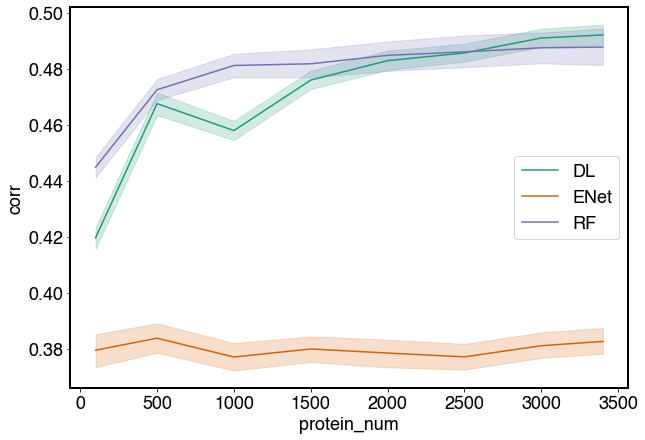

In [88]:
sns.lineplot(x='protein_num',
             y='corr',
             data=all_df,
#              err_style="bars",
             markers=True,
             label="DL")
sns.lineplot(x='protein_num',
             y='corr',
             data=all_df_enet,
#              err_style="bars",
             markers=True,
             label="ENet")
sns.lineplot(x='protein_num',
             y='corr',
             data=all_df_rf,
#              err_style="bars",
             markers=True,
             label="RF")

In [54]:
all_df.groupby(['protein_num']).mean()

,corr,experiment
protein_num,,
100,0.391472,4.5
500,0.424552,4.5
1000,0.436322,4.5
1500,0.446321,4.5
2000,0.454185,4.5
2500,0.461616,4.5
3000,0.465634,4.5
3400,0.469220,4.5


## test + CV

In [7]:
col = ['test_corr', 'cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr']
sizes = [100, 500, 1000, 1500, 2000, 2500, 3000, 3400]

In [8]:
all_df_enet = []
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample/ElasticNet/downsample{size}/"
                   ).rglob("scores*"):
        tmp_score = pd.read_csv(fp)
        tmp_score_long = pd.melt(tmp_score,
                                 id_vars='drug_id',
                                 value_vars=col,
                                 var_name='run',
                                 value_name='corr')
        tmp_score_long = tmp_score_long.dropna()
#         tmp_score_long = tmp_score_long.fillna(0)
        tmp_df = tmp_score_long.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    one_size_df = pd.concat(one_size_df)
    one_size_df['protein_num'] = size
    all_df_enet.append(one_size_df)
all_df_enet = pd.concat(all_df_enet)

In [9]:
all_df_rf = []
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample/RandomForest/downsample{size}/"
                   ).rglob("scores*"):
        tmp_score = pd.read_csv(fp)
        tmp_score_long = pd.melt(tmp_score,
                                 id_vars='drug_id',
                                 value_vars=col,
                                 var_name='run',
                                 value_name='corr')
#         tmp_score_long = tmp_score_long.dropna()
        tmp_score_long = tmp_score_long.fillna(0)
        tmp_df = tmp_score_long.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    one_size_df = pd.concat(one_size_df)
    one_size_df['protein_num'] = size
    all_df_rf.append(one_size_df)
all_df_rf = pd.concat(all_df_rf)

In [88]:
all_df = []
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample/DL/downsample{size}/").rglob("scores*"):
        tmp_score = pd.read_csv(fp)
#         if re.match(".*run_[3-9].*", str(fp)):
#             continue
        max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(['epoch']).mean()['corr'].reset_index()
        protein_epoch = max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'].values[0]
        tmp_test = tmp_score[(tmp_score['run'] == 'test')
                                & (tmp_score['epoch'] == protein_epoch)][[
                                    'drug_id', 'run', 'corr'
                                ]].reset_index(drop=True)

        tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
        tmp_cv_long = deep_learning_cv_score(tmp_cv)
        tmp_df = pd.concat([tmp_test, tmp_cv_long])
#         tmp_df = tmp_test.copy()
        tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    if len(one_size_df) > 0:
        one_size_df = pd.concat(one_size_df)
        one_size_df['protein_num'] = size
        all_df.append(one_size_df)
all_df = pd.concat(all_df)

In [95]:
all_df_rna = []
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample_rna/DL/downsample{size}/"
                   ).rglob("scores*"):
        if '202009291031_res_1000' in str(fp):
            continue
#         if re.match(".*run_[3-9].*", str(fp)):
#             continue
        tmp_score = pd.read_csv(fp)
        max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(
            ['epoch']).mean()['corr'].reset_index()
        protein_epoch = max_epoch[max_epoch['corr'] ==
                                  max_epoch['corr'].max()]['epoch'].values[0]
        tmp_test = tmp_score[(tmp_score['run'] == 'test')
                             & (tmp_score['epoch'] == protein_epoch)][[
                                 'drug_id', 'run', 'corr'
                             ]].reset_index(drop=True)

        tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
        tmp_cv_long = deep_learning_cv_score(tmp_cv)
        tmp_df = pd.concat([tmp_test, tmp_cv_long])
        #         tmp_df = tmp_test.copy()
        tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    if len(one_size_df) > 0:
        one_size_df = pd.concat(one_size_df)
        one_size_df['protein_num'] = size
        all_df_rna.append(one_size_df)
all_df_rna = pd.concat(all_df_rna)

Text(0, 0.5, "Mean Pearson's r")

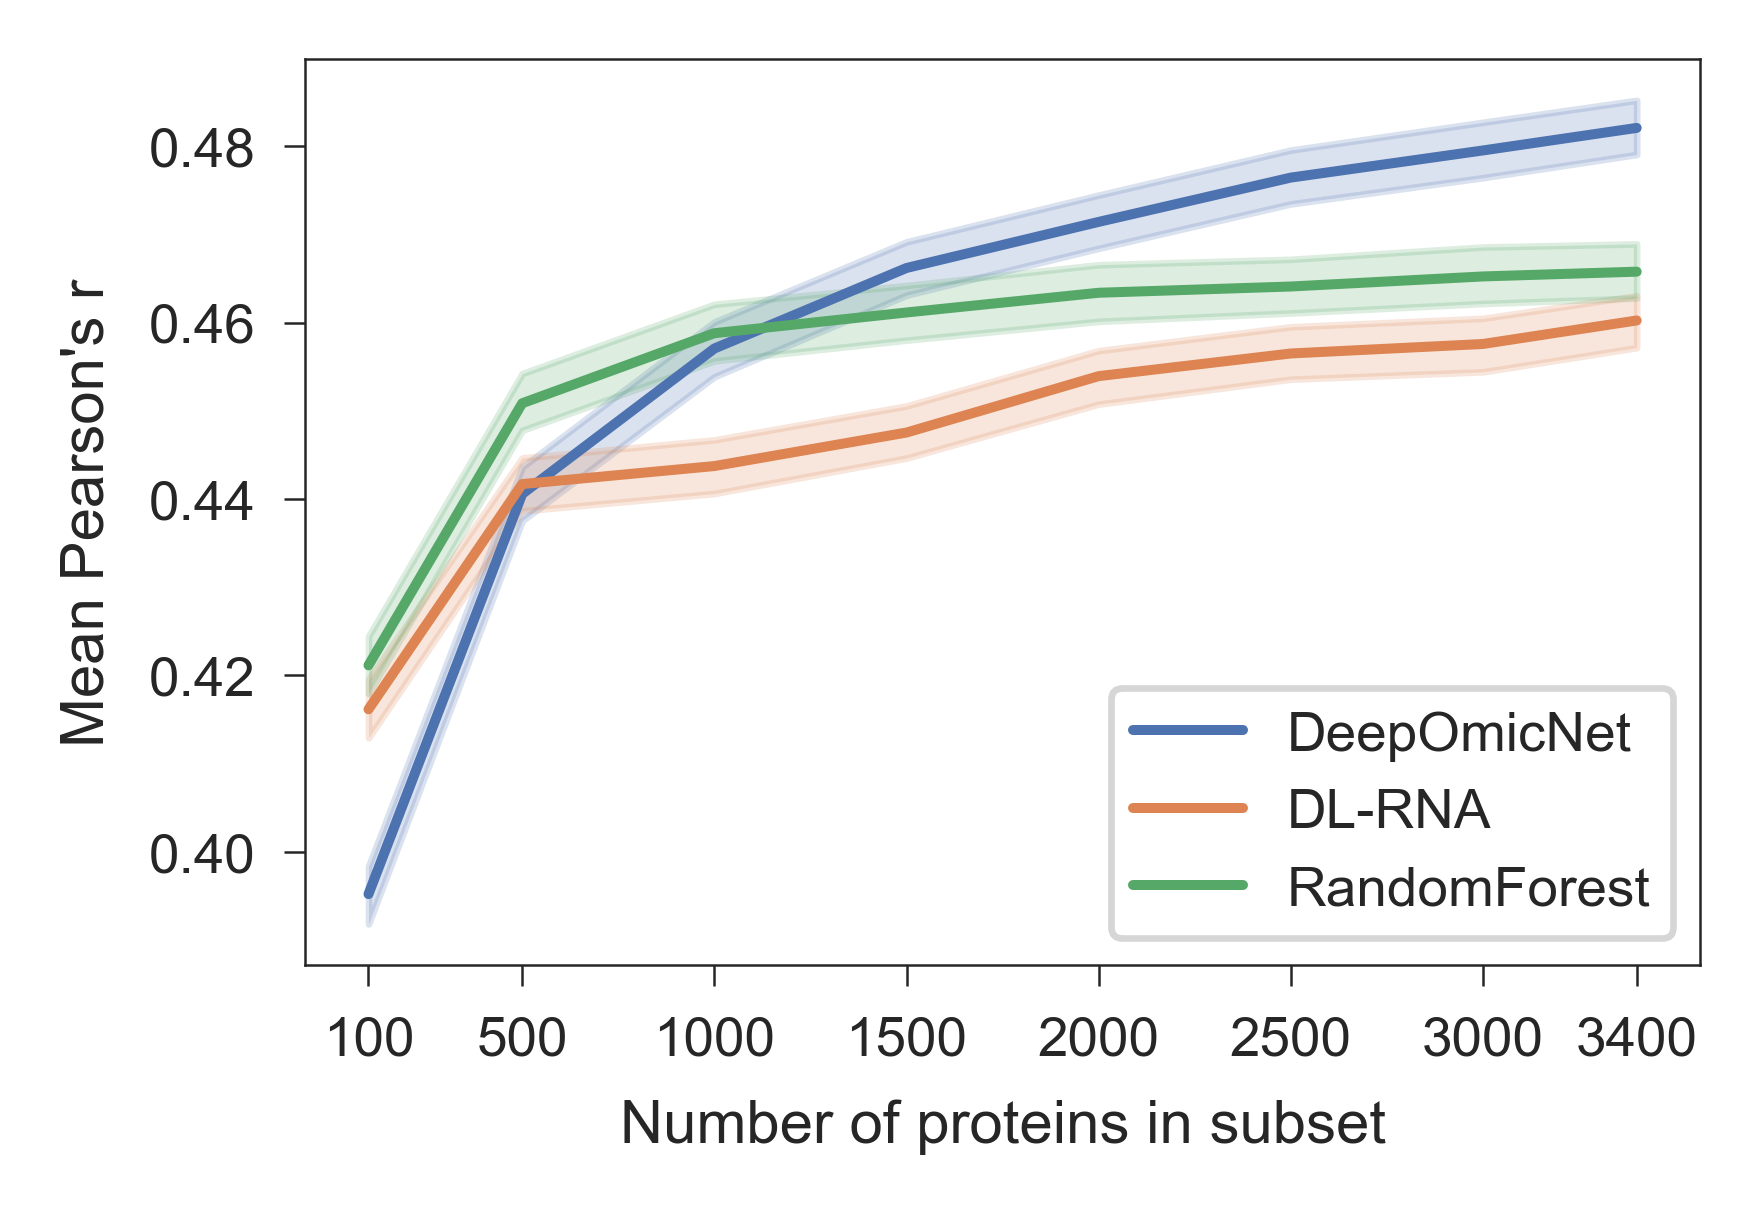

In [100]:
_, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=600)

sns.lineplot(x='protein_num',
             y='corr',
             data=all_df,
             label="DeepOmicNet")
sns.lineplot(x='protein_num',
             y='corr',
             data=all_df_rna,
             label="DL-RNA")
# sns.lineplot(x='protein_num',
#              y='corr',
#              data=all_df_enet,
#              label="ENet")
sns.lineplot(x='protein_num',
             y='corr',
             data=all_df_rf,
             label="RandomForest")
ax.set_xticks([100, 500, 1000, 1500, 2000, 2500, 3000, 3400])
plt.xlabel("Number of proteins in subset")
plt.ylabel("Mean Pearson's r")

# RNA common

## RF

In [21]:
col = ['test_corr', 'cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr']

In [22]:
def process_ml(df):
    tmp_score_long = pd.melt(df,
                             id_vars='drug_id',
                             value_vars=col,
                             var_name='run',
                             value_name='corr')
    #         tmp_score_long = tmp_score_long.dropna()
    tmp_score_long = tmp_score_long.fillna(0)
    #     tmp_df = tmp_score_long.groupby('drug_id').mean().reset_index()
    return tmp_score_long[['drug_id', 'corr']]


def process_dl(tmp_score):
    max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(
        ['epoch']).mean()['corr'].reset_index()
    protein_epoch = max_epoch[max_epoch['corr'] ==
                              max_epoch['corr'].max()]['epoch'].values[0]
    tmp_test = tmp_score[(tmp_score['run'] == 'test')
                         & (tmp_score['epoch'] == protein_epoch)][[
                             'drug_id', 'run', 'corr'
                         ]].reset_index(drop=True)

    tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
    tmp_cv_long = deep_learning_cv_score(tmp_cv)
    tmp_df = pd.concat([tmp_test, tmp_cv_long])
    #         tmp_df = tmp_test.copy()
    #     tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
    return tmp_df[['drug_id', 'corr']]

In [23]:
protein_all_rf = pd.read_csv("../../work_dirs/protein/RandomForest/scores_202006181311_ruv_min_300_eg_id.csv")
protein_all_rf = process_ml(protein_all_rf)
protein_all_rf['corr'].mean()
protein_all_rf['category'] = 'Protein'

In [24]:
rna_all_rf = pd.read_csv("../../work_dirs/rna/RandomForest/scores_202006191030_rna_300_eg_id.csv")
rna_all_rf = process_ml(rna_all_rf)
rna_all_rf['corr'].mean()
rna_all_rf['category'] = 'RNA (all genes)'

In [25]:
rna_common_rf = pd.read_csv("../../work_dirs/rna_common/RandomForest/scores_202009271709_rna_300_eg_id.csv")
rna_common_rf = process_ml(rna_common_rf)
rna_common_rf['corr'].mean()
rna_common_rf['category'] = 'RNA (overlapping genes)'

In [26]:
rf_data = pd.concat([protein_all_rf, rna_all_rf, rna_common_rf])
rf_data['Model'] = 'RandomForest'

## DL

In [27]:
protein_all_dl = pd.read_csv("../../work_dirs/protein/MultiDrug/scores_202006191021_resx_ruv_zero_300_eg_id.csv")
protein_all_dl = process_dl(protein_all_dl)
protein_all_dl['corr'].mean()
protein_all_dl['category'] = 'Protein'

In [28]:
rna_all_dl = pd.read_csv("../../work_dirs/rna/MultiDrug/scores_202006181624_res_eg_id.csv")
rna_all_dl = process_dl(rna_all_dl)
rna_all_dl['corr'].mean()
rna_all_dl['category'] = 'RNA (all genes)'

In [29]:
rna_common_dl = pd.read_csv("../../work_dirs/rna_common/DL/scores_202009272108_res_eg_id.csv")
rna_common_dl = process_dl(rna_common_dl)
rna_common_dl['corr'].mean()
rna_common_dl['category'] = 'RNA (overlapping genes)'

In [30]:
dl_data = pd.concat([protein_all_dl, rna_all_dl, rna_common_dl])
dl_data['Model'] = 'DeepOmicNet'

In [31]:
plot_df = pd.concat([rf_data, dl_data])

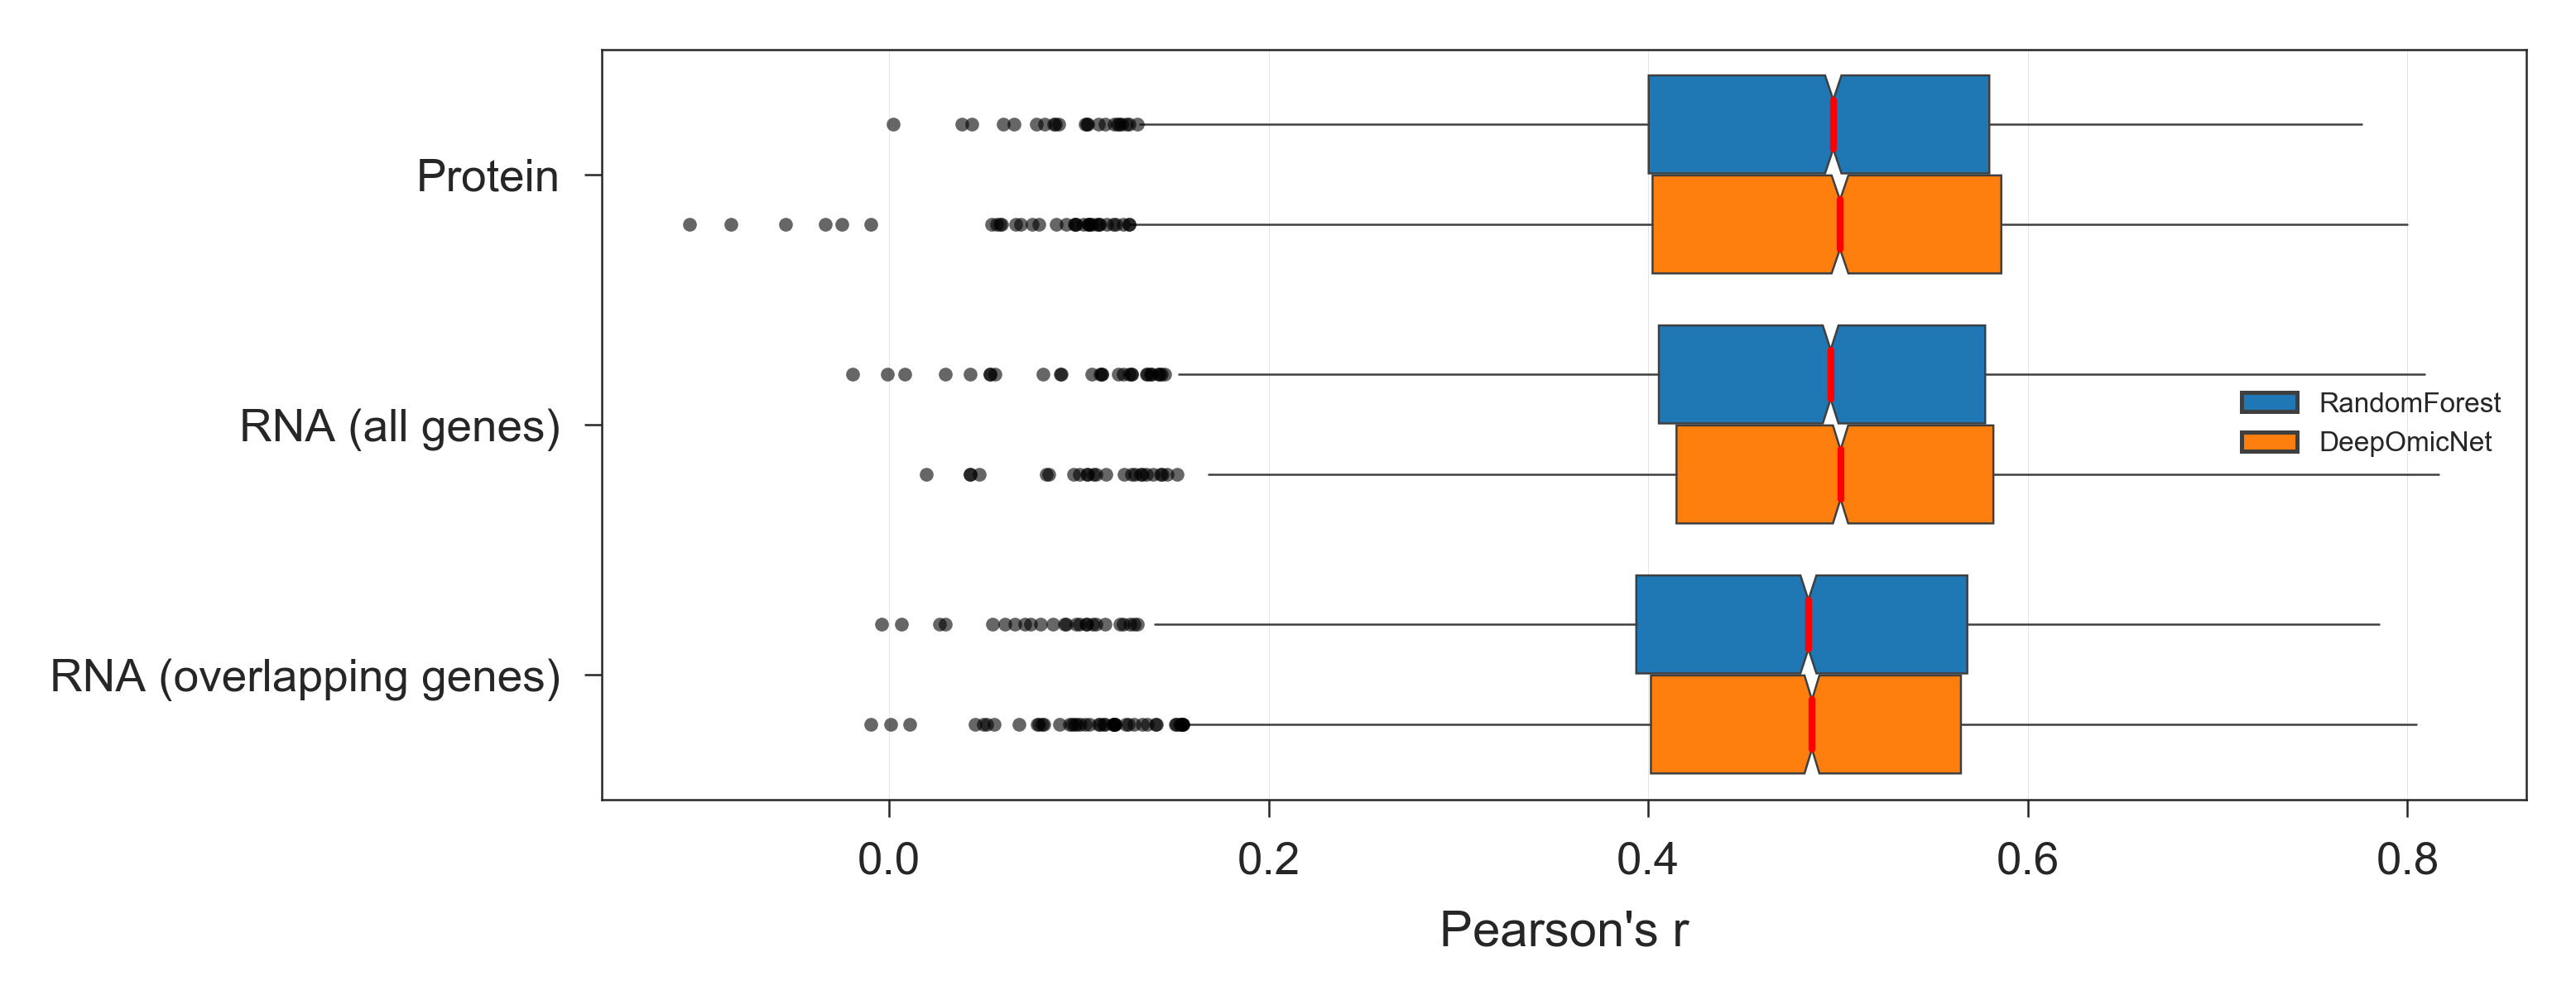

In [32]:
_, ax = plt.subplots(1, 1, figsize=(5, 2), dpi=600)

sns.boxplot(
    x="corr",
    y="category",
    hue="Model",
    data=plot_df,
#     order=order,
    notch=True,
    boxprops=dict(linewidth=0.3),
    whiskerprops=dict(linewidth=0.3),
    medianprops=CrispyPlot.MEDIANPROPS,
    flierprops=CrispyPlot.FLIERPROPS,
    palette="tab10",
    showcaps=False,
    saturation=1,
    orient="h",
    ax=ax,
)

ax.set_xlabel("Pearson's r")
ax.set_ylabel("")
ax.grid(axis="x", lw=0.1, color="#e1e1e1", zorder=0)

ax.legend(prop={"size": 4}, frameon=False, title="")

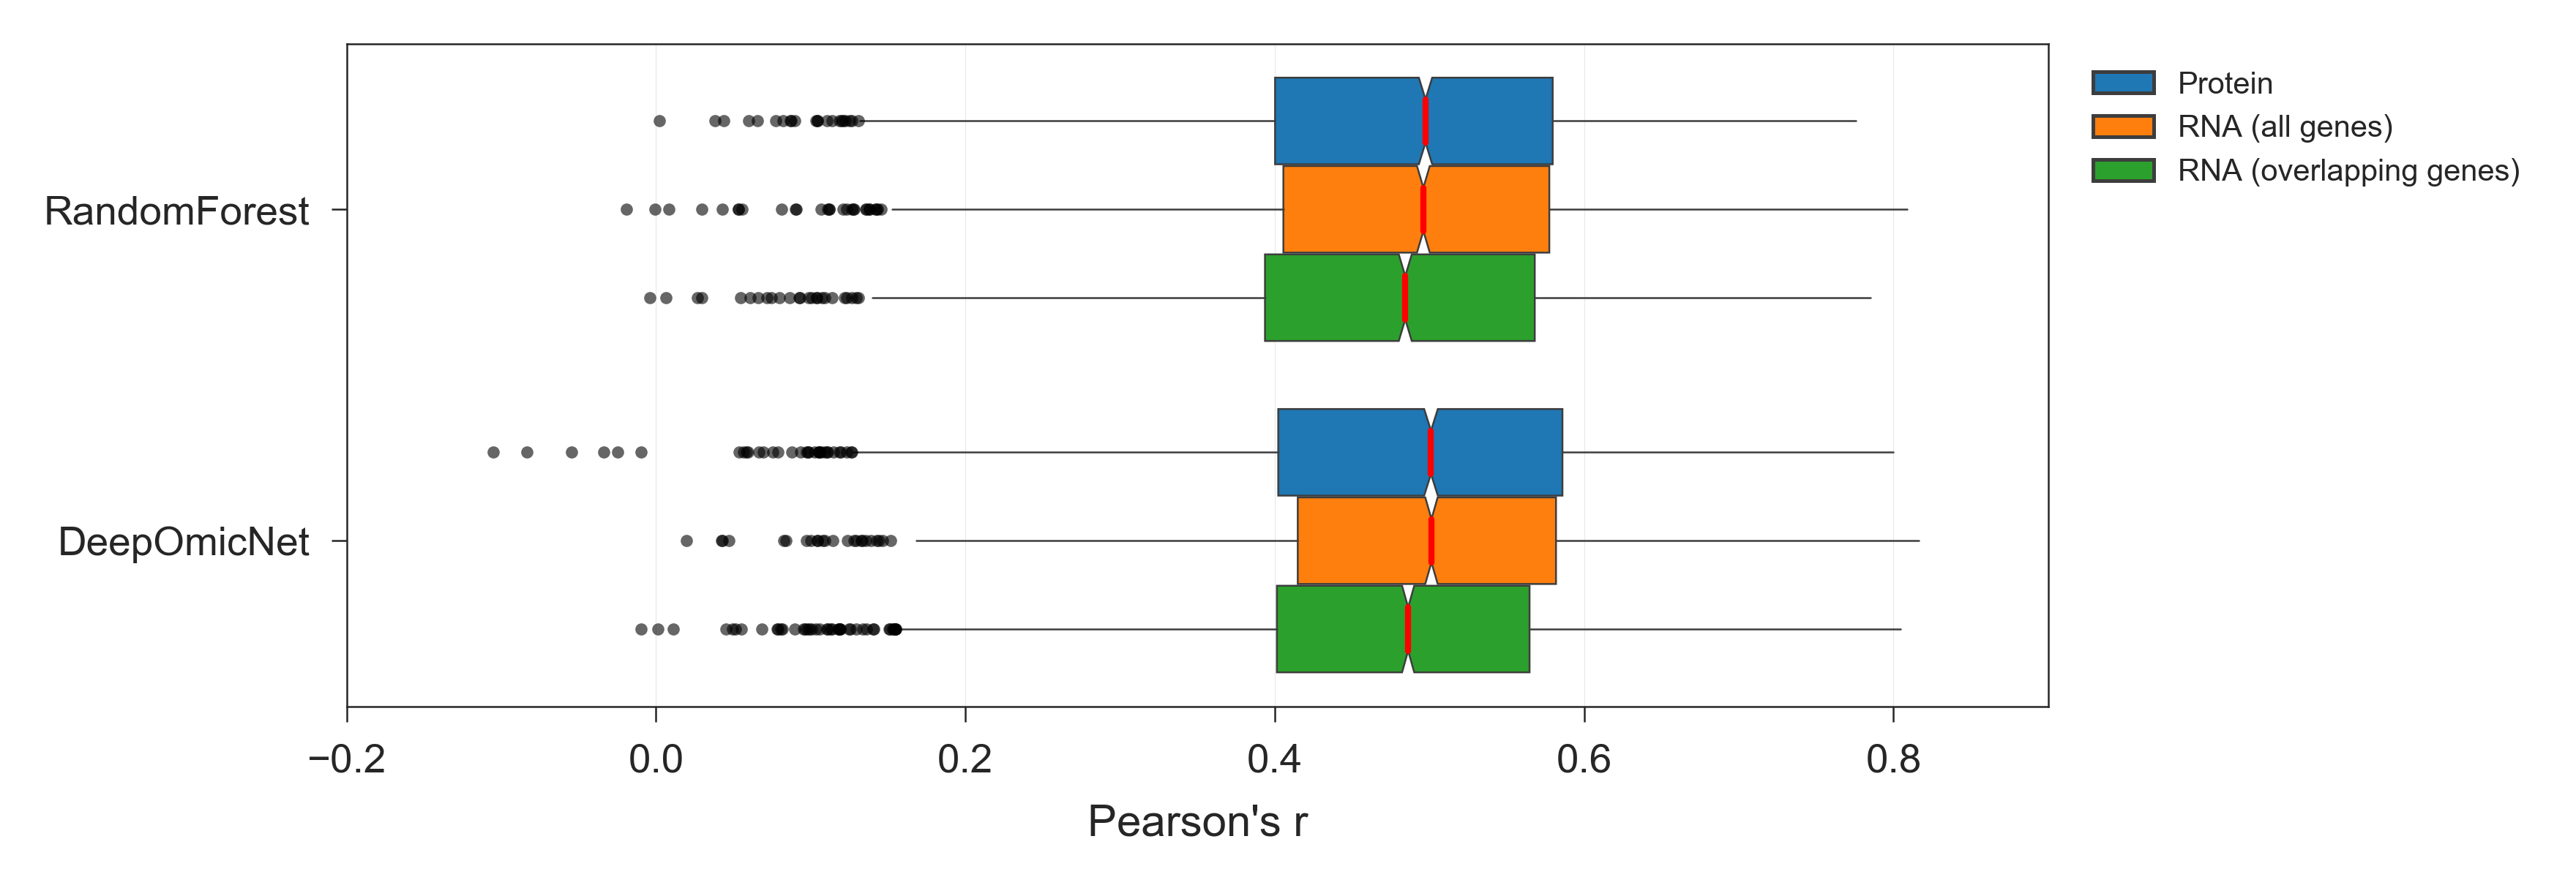

In [71]:
_, ax = plt.subplots(1, 1, figsize=(5, 2), dpi=600)

sns.boxplot(
    x="corr",
    y="Model",
    hue="category",
    data=plot_df,
#     order=order,
    notch=True,
    boxprops=dict(linewidth=0.3),
    whiskerprops=dict(linewidth=0.3),
    medianprops=CrispyPlot.MEDIANPROPS,
    flierprops=CrispyPlot.FLIERPROPS,
    palette="tab10",
    showcaps=False,
    saturation=1,
    orient="h",
    ax=ax,
)

ax.set_xlabel("Pearson's r")
ax.set_ylabel("")
ax.grid(axis="x", lw=0.1, color="#e1e1e1", zorder=0)

# y1, y2 = 0.73, 1.27  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
# x, w, col = plot_df['corr'].max() + 0.02, 0.02, 'k'
# ax.plot([x, x+w, x+w, x], [y1, y1, y2, y2], lw=0.5, c=col)
# ax.text((x + w) + .02,
#            (y1+y2)/2,
#            r"$\bf{*}\bf{*}\bf{*}$",
#            ha='center',
#            va='center',
#            size=4)
ax.set_xlim(-0.2,0.9)
ax.legend(prop={"size": 5}, frameon=False, title="", loc=2, bbox_to_anchor=(1.01, 1))


In [40]:
ttest_rel(
    dl_data.query('category == "Protein"')['corr'],
    dl_data.query('category == "RNA (overlapping genes)"')['corr'])

Ttest_relResult(statistic=12.697826925250533, pvalue=2.743908868252424e-36)

In [41]:
ttest_rel(
    rf_data.query('category == "Protein"')['corr'],
    rf_data.query('category == "RNA (overlapping genes)"')['corr'])

Ttest_relResult(statistic=6.775389068872667, pvalue=1.4103244418169183e-11)

In [43]:
ttest_rel(
    rf_data.query('category == "RNA (all genes)"')['corr'],
    rf_data.query('category == "RNA (overlapping genes)"')['corr'])

Ttest_relResult(statistic=8.329679278131598, pvalue=1.0807094752053684e-16)

# L1000 overlap

In [4]:
l1000 = [x.strip() for x in open("../../data/L1000_gene_list.txt", "r").readlines()]

In [29]:
protein_all = pd.read_csv(
    "../../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_update.txt",
    sep='\t').set_index('Cell_line').columns

In [14]:
protein_lists = pd.read_csv("../../data/protein/downsample/downsample_1000.csv")

In [16]:
name_map = pd.read_csv("../../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                               sep='\t',
                               names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()
protein2rna_map = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))
rna2protein_map = {v: k for k, v in protein2rna_map.items()}

In [19]:
l1000_protein = [rna2protein_map[x] for x in l1000 if x in rna2protein_map]

In [25]:
df = []
for i in range(10):
    l1000_set = set(l1000_protein)
    protein_set = set(protein_lists.iloc[:, i])
    l1000 = l1000_set - protein_set
    inter = l1000_set.intersection(protein_set)
    protein = protein_set - l1000_set
    df.append({
        'L1000': len(l1000),
        'intersection': len(inter),
        'protein': len(protein)
    })
df = pd.DataFrame(df)

In [26]:
df

,L1000,intersection,protein
0,955,88,912
1,974,69,931
2,951,92,908
3,966,77,923
4,979,64,936
5,969,74,926
6,965,78,922
7,958,85,915
8,958,85,915
9,951,92,908


In [32]:
print(len(set(l1000) - set(protein_all)))
print(len(set(l1000).intersection(set(protein_all))))
print(len(set(protein_all) - set(l1000)))

761
190
3235
